# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1196,C72529736J,Smart Coupe,economy,petrol,4.40,2017,111542,2020,38.15,electro_bug
1167,g15598327l,Smart ForTwo,economy,petrol,2.74,2015,85211,2017,33.45,electro_bug
1990,g11810192a,VW Tiguan,economy,petrol,3.24,2016,115460,2021,66.97,engine_check
1604,l-6384509w,Smart ForTwo,economy,petrol,6.98,2014,66214,2017,50.55,engine_check
402,v-1155372j,Kia Sportage,standart,petrol,4.70,2013,40945,2022,49.64,engine_ignition


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
344016,m16487914i,Y21096922W,g1V,2020-01-10,2.58,44,391,28,48.000000,1,944.998686,0,-3.350036,0.745
84446,q12711233W,G-1211626R,w1S,2020-01-30,3.29,64,828,34,112.000000,6,655.273871,0,11.902120,-10.763
399962,V19898735X,c-7401486X,N1v,2020-02-28,6.70,17852,232072,44,76.529398,0,807474.825681,0,NaN,-3.529
142829,G57733957J,K-2047259i,I1d,2020-03-20,5.77,58,690,52,75.000000,1,2296.274180,0,5.992029,-5.500
695124,V18603964h,w45505269O,b1a,2020-03-30,7.96,37,475,41,55.000000,0,1208.808065,0,11.396697,-35.317


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
14566,20,8.9,680,18.0,d16061829G,1,2019-5-18
12171,19,7.2,641,13.0,K53852012D,1,2020-8-1
7869,33,7.7,459,2.0,M79174936R,1,2020-6-12
11180,18,8.9,725,23.0,E41456640y,1,2020-8-20
12789,36,8.0,74,5.0,u15958426d,0,2019-10-25


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
87102,z-2004787O,OJ,2019-1-7 17:30,reparking,1.0,30
58191,y21647488o,UB,2020-3-6 19:50,reparking,1.0,28
111647,a-2111343W,HO,2019-4-19 3:32,reparking,1.0,22
30985,u12928592s,XC,2019-9-30 8:16,reparking,1.0,28
25925,N-1087986g,CL,2021-5-13 18:46,repair,6.2,24


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [6]:
# Для каждой машины несколько признаков
rides_group = rides_info.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    min_rating = ('rating', 'min'),
    all_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    alL_rides = ('ride_id', 'count'),

    # добавляю сразу признаки на свой выбор
    avg_ride_cost = ('ride_cost', 'mean'),
    avg_speed = ('speed_avg', 'mean'),
    mean_distance = ('distance', 'mean'),
)

# Cоединение таблиц
data = pd.merge(car_train, rides_group, on='car_id')

# Подключение информации про водителей и про ремонт машин
data = pd.merge(data, rides_info[['car_id', 'user_id']], on='car_id')
data = pd.merge(data, driver_info[['user_id', 'age', 'user_rating', 'user_rides']], on='user_id')
data = pd.merge(data, fix_info[['car_id', 'worker_id', 'fix_date', 'work_type']], on='car_id')

data.head()

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,avg_ride_cost,avg_speed,mean_distance,user_id,age,user_rating,user_rides,worker_id,fix_date,work_type
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,PG,2019-8-10 9:29,reparking
1,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,HH,2019-2-9 10:49,repair
2,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,UF,2020-4-8 10:23,reparking
3,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,LC,2019-5-23 10:42,reparking
4,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,20106.873563,44.66092,69777.646008,n14703870u,38,7.4,268,AF,2020-7-24 18:32,repair


## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [7]:
# Удаление констант и уникальных значений
columns_with_id = [col for col in data.columns if '_id' in col]

data = data.loc[:, data.apply(pd.Series.nunique) != 1]
data = data.drop(columns_with_id, axis=1)
data = data.dropna(axis=1)
data.head()

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,...,all_distance,speed_max,avg_ride_cost,avg_speed,mean_distance,age,user_rating,user_rides,fix_date,work_type
0,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-8-10 9:29,reparking
1,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-2-9 10:49,repair
2,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2020-4-8 10:23,reparking
3,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2019-5-23 10:42,reparking
4,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,4.737759,...,1.214131e+07,180.855726,20106.873563,44.66092,69777.646008,38,7.4,268,2020-7-24 18:32,repair


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13970460 entries, 0 to 13970459
Data columns (total 21 columns):
 #   Column         Dtype  
---  ------         -----  
 0   model          object 
 1   car_type       object 
 2   fuel_type      object 
 3   car_rating     float64
 4   year_to_start  int64  
 5   riders         int64  
 6   year_to_work   int64  
 7   target_reg     float64
 8   target_class   object 
 9   mean_rating    float64
 10  min_rating     float64
 11  all_distance   float64
 12  speed_max      float64
 13  avg_ride_cost  float64
 14  avg_speed      float64
 15  mean_distance  float64
 16  age            int64  
 17  user_rating    float64
 18  user_rides     int64  
 19  fix_date       object 
 20  work_type      object 
dtypes: float64(10), int64(5), object(6)
memory usage: 2.2+ GB


In [9]:
data.shape

(13970460, 21)

Чересчур много значений получилось, убавлю до 2000 для оптимизации

In [10]:
data = data.sample(n=2000)

In [11]:
data.shape

(2000, 21)

In [ ]:
# Удалю еще столбцы для оптимизации, так как очень много данных
# cols_drop = [
#     'mean_rating',
#     'min_rating',
#     'all_distance',
#     'avg_ride_cost',
#     'speed_max',
#     'avg_speed',
#     'mean_distance',
#     'year_to_work',
#     'target_reg',
# ]

# data = data.drop(columns = cols_drop)

In [ ]:
# Phik

# !pip install phik

# from phik import report
# phik_matrix = data.phik_matrix()

# print(phik_matrix)

# sns.heatmap(phik_matrix, annot=True, cmap='crest')
# plt.title("Phik Matrix")

Прошу прощения за "скукоженный график". Очень долго ждал выполнения ячейки, переделывать не стал.

In [ ]:
# data.info()

In [ ]:
# CatBoost

# !pip install catboost

# from catboost import CatBoostRegressor, Pool, CatBoostClassifier
# from sklearn.model_selection import train_test_split

# cat_cols = list(data.select_dtypes(include=['object']).columns)
# cat_cols.remove('target_class')

# X = data.drop(columns = 'target_class')
# y = data['target_class']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# model = CatBoostClassifier(random_state=42, cat_features=cat_cols)
# model.fit(X_train, y_train, plot=True)

# results = model.get_feature_importance()
# print(results)

In [ ]:
# results = model.get_feature_importance(prettified=True)
# results

In [ ]:
# X.columns

In [16]:
# Shap

!pip install shap -q

import shap

# explain = shap.TreeExplainer(model)
# values = explain.shap_values(X_train)

# shap.summary_plot(values, X_train)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 3.0 MB/s eta 0:00:00


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [12]:
!pip install catboost -q

from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 3.0 MB/s eta 0:00:00


In [13]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
cat_cols.remove('target_class')

num_cols = list(data.select_dtypes(exclude=['object']).columns)

targets = ['target_class'] # таргеты
cat_features = cat_cols # категориальные признаки
num_features = num_cols # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

Категориальные признаки: 5 ['model', 'car_type', 'fuel_type', 'fix_date', 'work_type']
Числовые признаки: 15 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'mean_rating', 'min_rating', 'all_distance', 'speed_max', 'avg_ride_cost', 'avg_speed', 'mean_distance', 'age', 'user_rating', 'user_rides']
Целевые переменные ['target_class']


In [14]:
X = data[num_features]
y = data[targets]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Запуск CatBoostClassifier без тюнинга
model = CatBoostClassifier(random_state=42, verbose=False)
model.fit(X_train, y_train, eval_set=(X_test, y_test))

results = model.predict(X_test)
accuracy = accuracy_score(y_test, results)
print(accuracy)

0.925


In [15]:
print("Лучшая итерация:", model.get_best_iteration())
print("Всего итераций прошло:", model.get_all_params()['iterations'])

Лучшая итерация: 532
Всего итераций прошло: 1000


# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

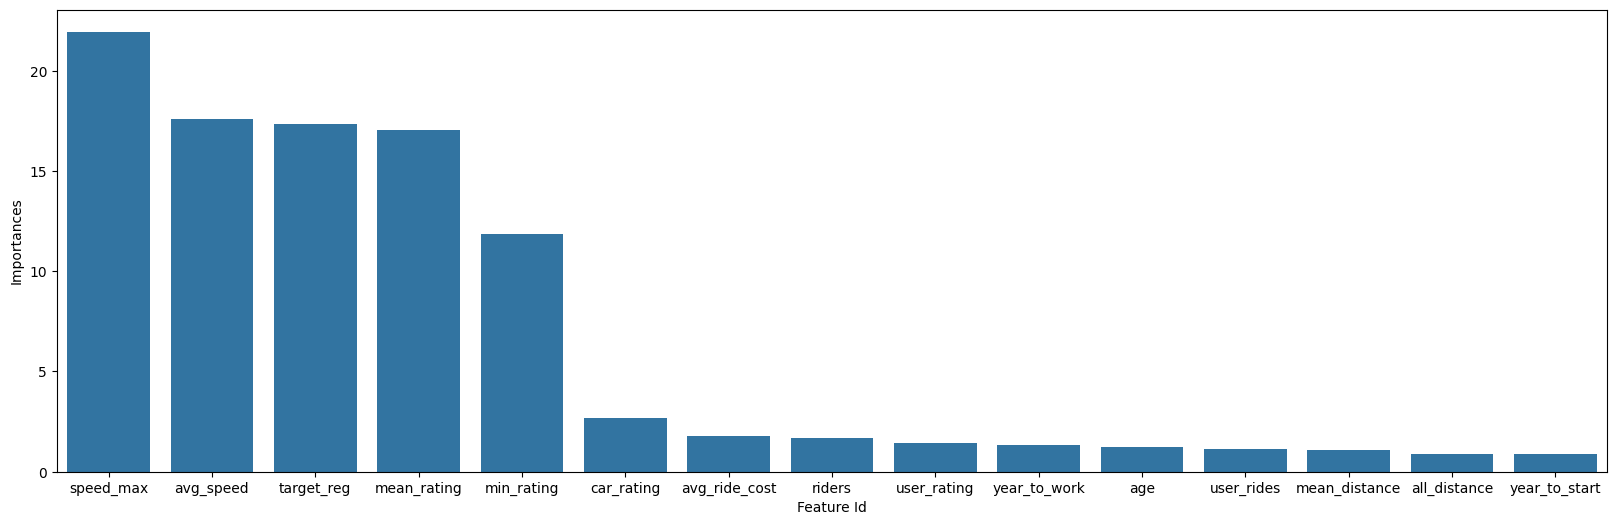

In [17]:
# Встроенный метод в CatBoost

results = model.get_feature_importance(prettified=True)

plt.figure(figsize=(20, 6))
sns.barplot(x='Feature Id', y='Importances', data=results);

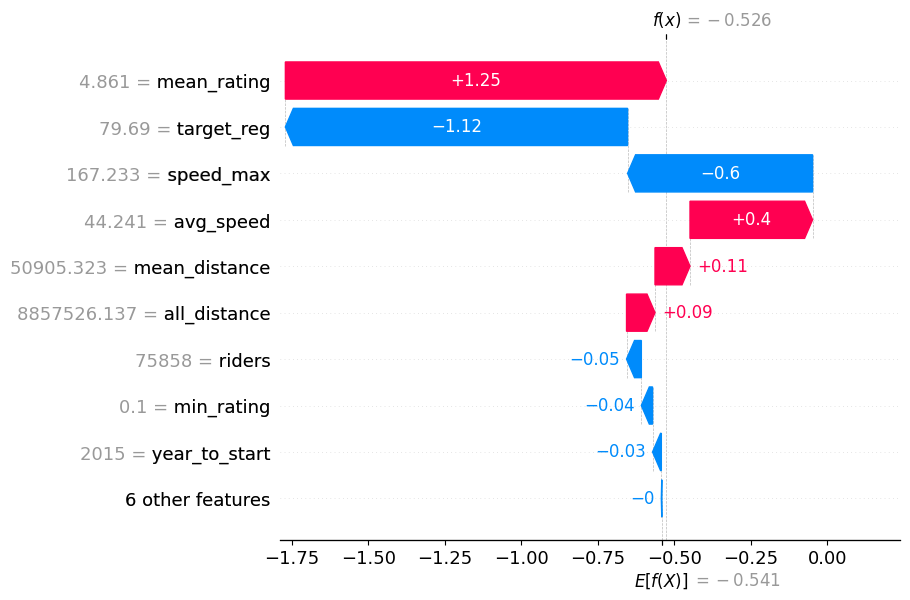

In [18]:
# waterfall_plot

Explainer = shap.Explainer(model)
shap_values = Explainer(X_test)
shap.waterfall_plot(shap_values[0, :, 1])

In [19]:
# classification_report
print(classification_report(y_test, model.predict(X_test)))

                 precision    recall  f1-score   support

    another_bug       0.98      0.95      0.96        92
      break_bug       1.00      1.00      1.00        62
    electro_bug       1.00      0.98      0.99        63
   engine_check       0.92      0.97      0.94        60
    engine_fuel       0.82      0.77      0.80        53
engine_ignition       0.88      0.94      0.91        63
engine_overheat       0.83      0.83      0.83        77
     gear_stick       0.94      0.97      0.95        86
    wheel_shake       0.93      0.89      0.91        44

       accuracy                           0.93       600
      macro avg       0.92      0.92      0.92       600
   weighted avg       0.93      0.93      0.92       600



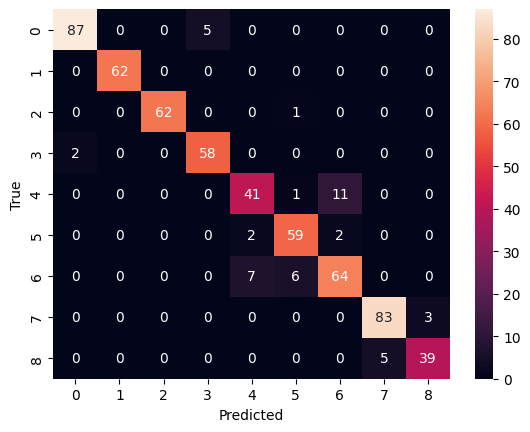

In [20]:
# confusion_matrix
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True)
plt.xlabel("Predicted")
plt.ylabel("True");

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
!pip install optuna -q
import optuna

def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  parameters = {
    'iterations': trial.suggest_int('iterations', 100, 1500),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'depth': trial.suggest_int('depth', 1, 10),
  }

  model = CatBoostClassifier(**parameters, random_state=42)
  model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

  results = model.predict(X_test)
  accuracy = accuracy_score(y_test, results)
  return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=10)

[I 2024-03-31 12:10:29,903] A new study created in memory with name: no-name-685b16c4-7f7a-4771-bd2d-e1fa6edaf119
[I 2024-03-31 12:12:18,484] Trial 0 finished with value: 0.9016666666666666 and parameters: {'iterations': 723, 'learning_rate': 0.01615160183779383, 'depth': 9}. Best is trial 0 with value: 0.9016666666666666.
[I 2024-03-31 12:12:23,921] Trial 1 finished with value: 0.9116666666666666 and parameters: {'iterations': 1379, 'learning_rate': 0.055750001346687644, 'depth': 3}. Best is trial 0 with value: 0.9016666666666666.
[I 2024-03-31 12:13:17,640] Trial 2 finished with value: 0.92 and parameters: {'iterations': 1410, 'learning_rate': 0.07584118793798891, 'depth': 7}. Best is trial 0 with value: 0.9016666666666666.
[I 2024-03-31 12:13:20,078] Trial 3 finished with value: 0.895 and parameters: {'iterations': 906, 'learning_rate': 0.07113136716326933, 'depth': 2}. Best is trial 3 with value: 0.895.
[I 2024-03-31 12:15:20,221] Trial 4 finished with value: 0.9166666666666666 and

In [ ]:
b_model = CatBoostClassifier(iterations=1410, learning_rate=0.07584118793798891, depth=7, random_state=42)
b_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

b_results = b_model.predict(X_test)
b_accuracy = accuracy_score(y_test, b_results)

print("Best accuracy:", b_accuracy)

Best accuracy: 0.92


**Метрику Accuracy удалось увеличить, пускай и не на очень много, но всё же подбор гиперпараметров помог достичь поставленной цели домашнего задания №3.**

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [22]:
!pip install optuna -q
import optuna

def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  parameters = {
    'iterations': trial.suggest_int('iterations', 100, 1000),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
    'depth': trial.suggest_int('depth', 1, 8),
  }

  model = CatBoostClassifier(**parameters, random_state=42)
  model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

  results = model.predict(X_test)
  accuracy = accuracy_score(y_test, results)
  return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2024-04-03 17:29:08,629] A new study created in memory with name: no-name-48f0bc55-4825-45d2-ac01-e6008c8d1d4f
[I 2024-04-03 17:30:48,764] Trial 0 finished with value: 0.925 and parameters: {'iterations': 725, 'learning_rate': 0.050817525539284925, 'depth': 8}. Best is trial 0 with value: 0.925.
[I 2024-04-03 17:31:27,174] Trial 1 finished with value: 0.925 and parameters: {'iterations': 863, 'learning_rate': 0.08691716489381394, 'depth': 7}. Best is trial 0 with value: 0.925.
[I 2024-04-03 17:31:30,444] Trial 2 finished with value: 0.9066666666666666 and parameters: {'iterations': 503, 'learning_rate': 0.05570286591132335, 'depth': 4}. Best is trial 2 with value: 0.9066666666666666.
[I 2024-04-03 17:33:07,656] Trial 3 finished with value: 0.9216666666666666 and parameters: {'iterations': 873, 'learning_rate': 0.010736386397296516, 'depth': 8}. Best is trial 2 with value: 0.9066666666666666.
[I 2024-04-03 17:33:09,922] Trial 4 finished with value: 0.9116666666666666 and parameters: 

In [23]:
b_model = CatBoostClassifier(iterations=863, learning_rate=0.08691716489381394, depth=7, random_state=42)
b_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

b_results = b_model.predict(X_test)
b_accuracy = accuracy_score(y_test, b_results)

print("Best accuracy of CatBoostClassifier:", b_accuracy)

Best accuracy of CatBoostClassifier: 0.925


In [24]:
!pip install lightgbm
from lightgbm import LGBMClassifier
!pip install optuna -q
import optuna

def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  parameters = {
    'num_leaves': trial.suggest_int('num_leaves', 10, 40),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
  }

  model = LGBMClassifier(**parameters, random_state=42)
  model.fit(X_train, y_train, eval_set=(X_test, y_test))

  results = model.predict(X_test)
  accuracy = accuracy_score(y_test, results)
  return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2024-04-03 17:35:14,422] A new study created in memory with name: no-name-ff4a78cf-e4b0-4965-8197-f5fa06bae377
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-04-03 17:35:15,383] Trial 0 finished with value: 0.9216666666666666 and parameters: {'num_leaves': 11, 'learning_rate': 0.054358989045365264}. Best is trial 0 with value: 0.9216666666666666.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-04-03 17:35:16,596] Trial 1 finished with value: 0.9283333333333333 and parameters: {'num_leaves': 29, 'learning_rate': 0.046435878718168976}. Best is trial 0 with value: 0.9216666666666666.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-04-03 17:35:17,210] Trial 2 finished with value: 0.9133333333333333 and parameters: {'num_leaves': 12, 'learning_rate': 0.01693244107416653}. Best is trial 2 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colum

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-04-03 17:35:18,344] Trial 3 finished with value: 0.9166666666666666 and parameters: {'num_leaves': 26, 'learning_rate': 0.014374555870472639}. Best is trial 2 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = colu

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

[I 2024-04-03 17:35:19,729] Trial 4 finished with value: 0.9316666666666666 and parameters: {'num_leaves': 35, 'learning_rate': 0.06677377000139074}. Best is trial 2 with value: 0.9133333333333333.


In [27]:
b_model = LGBMClassifier(num_leaves=35, learning_rate=0.06677377000139074, random_state=42)
b_model.fit(X_train, y_train, eval_set=(X_test, y_test))

b_results = b_model.predict(X_test)
b_accuracy = accuracy_score(y_test, b_results)

print("Best accuracy of LGBMClassifier:", b_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2617
[LightGBM] [Info] Number of data points in the train set: 1400, number of used features: 15
[LightGBM] [Info] Start training from score -2.096733
[LightGBM] [Info] Start training from score -2.132240
[LightGBM] [Info] Start training from score -2.175323
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.233592
[LightGBM] [Info] Start training from score -2.102564
[LightGBM] [Info] Start training from score -2.181632
[LightGBM] [Info] Start training from score -2.562096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [29]:
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
!pip install optuna -q
import optuna

def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, LabelEncoder().fit_transform(y), test_size=0.3, random_state=42)

  parameters = {
    'max_depth': trial.suggest_int('max_depth', 1, 8),
    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
  }

  model = XGBClassifier(**parameters, random_state=42)
  model.fit(X_train, y_train)

  results = model.predict(X_test)
  accuracy = accuracy_score(y_test, results)
  return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2024-04-03 17:37:48,592] A new study created in memory with name: no-name-6a74bf89-de64-4d41-b2d3-14105bfc0106
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2024-04-03 17:37:49,679] Trial 0 finished with value: 0.9133333333333333 and parameters: {'max_depth': 7, 'learning_rate': 0.03932491062269535}. Best is trial 0 with value: 0.9133333333333333.
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2024-04-03 17:37:49,942] Trial 1 finished with value: 0.8183333333333334 and parameters: {'max_depth': 1, 'learning_rate': 0.010024807304876706}. Best is t

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, LabelEncoder().fit_transform(y), test_size=0.3, random_state=42)
b_model = XGBClassifier(max_depth=7, learning_rate=0.0612849754764596, random_state=42)
b_model.fit(X_train, y_train)

b_results = b_model.predict(X_test)
b_accuracy = accuracy_score(y_test, b_results)

print("Best accuracy of XGBClassifier:", b_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best accuracy of XGBClassifier: 0.9166666666666666


In [33]:
from sklearn.ensemble import RandomForestClassifier
!pip install optuna -q
import optuna

def objective(trial):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

  parameters = {
    'n_estimators': trial.suggest_int('n_estimators', 20, 100),
    'max_depth': trial.suggest_int('max_depth', 1, 8),
  }

  model = RandomForestClassifier(**parameters, random_state=42)
  model.fit(X_train, y_train)

  results = model.predict(X_test)
  accuracy = accuracy_score(y_test, results)
  return accuracy

study = optuna.create_study()
study.optimize(objective, n_trials=5)

[I 2024-04-03 17:40:45,167] A new study created in memory with name: no-name-c78a95b5-1a9b-4c94-a07a-95e5c57d8bb6
<ipython-input-33-4e18555fe0b7>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[I 2024-04-03 17:40:45,841] Trial 0 finished with value: 0.8533333333333334 and parameters: {'n_estimators': 94, 'max_depth': 3}. Best is trial 0 with value: 0.8533333333333334.
<ipython-input-33-4e18555fe0b7>:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[I 2024-04-03 17:40:46,746] Trial 1 finished with value: 0.9083333333333333 and parameters: {'n_estimators': 36, 'max_depth': 8}. Best is trial 0 with value: 0.8533333333333334.
<ipython-input-33-4e18555fe0b7>:14: DataConversionWarning: A column-vector y was passed 

In [34]:
b_model = RandomForestClassifier(n_estimators=36, max_depth=8, random_state=42)
b_model.fit(X_train, y_train)

b_results = b_model.predict(X_test)
b_accuracy = accuracy_score(y_test, b_results)

print("Best accuracy of RandomForestClassifier:", b_accuracy)

Best accuracy of RandomForestClassifier: 0.9083333333333333


### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.